### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
from matplotlib import pyplot as plt

from dqn_agent import Agent

In [3]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
from dqn_agent import Agent

action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [5]:
def dqn(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    score = 0
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = state["BananaBrain"].vector_observations
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 25 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=2000.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-25, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'simple_dqn_checkpoint.pth')
            break
    return scores

scores = dqn()

Episode 25	Average Score: -1.12
Episode 50	Average Score: -4.64
Episode 75	Average Score: -1.49
Episode 100	Average Score: 2.71
Episode 125	Average Score: 10.03
Episode 150	Average Score: 32.58
Episode 175	Average Score: 72.47
Episode 200	Average Score: 135.21
Episode 225	Average Score: 225.31
Episode 250	Average Score: 345.50
Episode 275	Average Score: 493.21
Episode 300	Average Score: 662.29
Episode 325	Average Score: 850.73
Episode 350	Average Score: 1051.37
Episode 375	Average Score: 1259.09
Episode 400	Average Score: 1485.93
Episode 425	Average Score: 1730.22
Episode 450	Average Score: 1996.35

Environment solved in 426 episodes!	Average Score: 2007.61


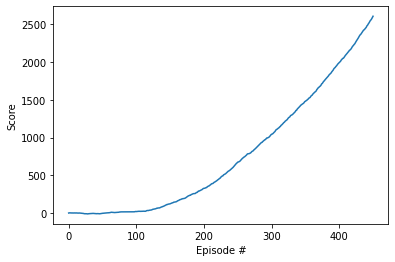

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test trained Model

In [16]:
env_info = env.reset(train_mode=True)[brain_name]

In [17]:
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [18]:
agent.qnetwork_local.load_state_dict(torch.load('simple_dqn_checkpoint.pth'))


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.0)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 16.0
